In [1]:
from itertools import chain

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
sns.set_style('darkgrid')

import os
from glob import glob

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from keras.models import load_model
import tensorflow as tf

In [2]:
!cp '../input/utilpy/util.py' './'

In [3]:
# import data
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('../input/data', 'images*', '*', '*.png'))}

print('Scans found:', len(all_image_paths), ', Total Rows', all_xray_df.shape[0])

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)



all_xray_df['Finding Labels']  = all_xray_df['Finding Labels'].replace('No Finding', '')

all_labels = list({x for l in all_xray_df['Finding Labels'].str.split('|') for x in l})


all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))


for c_label in all_labels:
    if len(c_label)> 1: 
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)


all_xray_df = all_xray_df.drop(['OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 
                               'Finding Labels',
                               'Follow-up #',
                               'OriginalImage[Width','Height]'
                               ], axis=1)

Scans found: 112120 , Total Rows 112120
All Labels (14): ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Consolidation', 'Mass', 'Infiltration', 'Pneumonia', 'Pneumothorax', 'Nodule', 'Pleural_Thickening', 'Fibrosis', 'Atelectasis', 'Edema']


In [4]:
print('Number of unique patients:' , all_xray_df['Patient ID'].nunique())

Number of unique patients: 30805


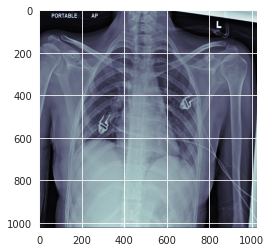

In [5]:
idx = all_xray_df['Patient Age'].sort_values().index[-2]
plt.imshow(plt.imread(all_xray_df.iloc[idx]['path']), cmap='bone')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='View Position', ylabel='count'>

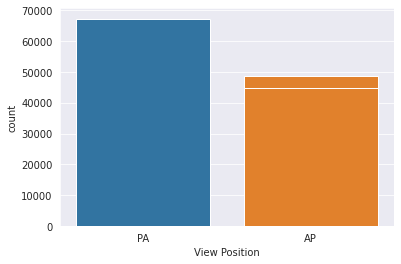

In [6]:
sns.countplot(all_xray_df['Patient Gender'])
sns.countplot(all_xray_df['View Position'])

In [7]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split

n = None
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)

for train_idx, test_idx in gss.split(all_xray_df[: n], groups = all_xray_df[: n]['Patient ID'].values):
    train_df = all_xray_df.iloc[train_idx]
    test_df, valid_df = train_test_split(all_xray_df.iloc[test_idx], 
                                   test_size = 0.5, 
                                   random_state = 42)
    
train_df.head()
test_df.head()

,Image Index,Patient ID,Patient Age,Patient Gender,View Position,path,Cardiomegaly,Emphysema,Effusion,Hernia,Consolidation,Mass,Infiltration,Pneumonia,Pneumothorax,Nodule,Pleural_Thickening,Fibrosis,Atelectasis,Edema
53848,00013594_029.png,13594,46,M,AP,../input/data/images_006/images/00013594_029.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13979,00003610_010.png,3610,30,F,PA,../input/data/images_002/images/00003610_010.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91299,00022776_005.png,22776,59,F,AP,../input/data/images_010/images/00022776_005.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4377,00001193_000.png,1193,52,F,PA,../input/data/images_001/images/00001193_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73092,00018006_009.png,18006,60,M,AP,../input/data/images_008/images/00018006_009.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=32, seed=1, target_w = 320, target_h = 320):     
    print("getting train generator...") 
    
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=32, seed=1, target_w = 320, target_h = 320):
    print("getting train and valid generators...")
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col=x_col, 
        y_col=y_cols, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    batch = raw_train_generator.next()
    data_sample = batch[0]


    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    

    image_generator.fit(data_sample)


    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [9]:
IMAGE_DIR = None
train_generator = get_train_generator(train_df, IMAGE_DIR, "path", all_labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "path", all_labels)

getting train generator...
Found 78566 validated image filenames.
getting train and valid generators...
Found 78566 validated image filenames.
Found 16777 validated image filenames.
Found 16777 validated image filenames.


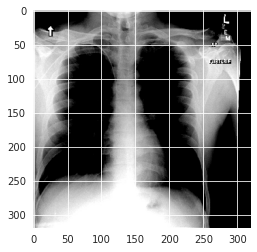

In [10]:
x, y = train_generator.__getitem__(2)
plt.imshow(x[0]);

In [11]:
def compute_class_freqs(labels):

    # total number of patients (rows)
    N = len(labels)
    
    positive_frequencies = (np.sum(labels, 0)) / N
    negative_frequencies = (1- positive_frequencies)

    return positive_frequencies, negative_frequencies



def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):


        loss = 0.0

        for i in range(len(pos_weights)):

            loss += -1 * K.mean(pos_weights * y_true * K.log(y_pred + epsilon) + 
                          (1 - y_true) * neg_weights * K.log(1 - y_pred + epsilon))
            
        return loss
    
    return weighted_loss

freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [ ]:
print(freq_pos)

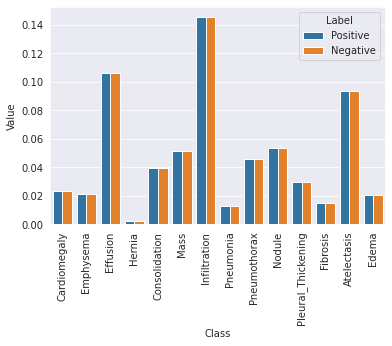

In [12]:
data = pd.DataFrame({"Class": all_labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": all_labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [13]:
import tensorflow.keras

In [14]:
base_model = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(all_labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights),metrics=['accuracy'])

checkpoint_path = 'xray_class_weights.best.hdf5'

2022-05-26 14:37:00.221106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 14:37:00.354061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 14:37:00.354843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 14:37:00.356770: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

29097984/29084464 [==============================] - 1s 0us/step


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4,
                              patience=3, min_lr=0.0001)

callbacks_list = [checkpoint, early, reduce_lr]


history = model.fit(train_generator, 
                    validation_data=valid_generator,
                    steps_per_epoch=100, 
                    validation_steps=50, 
                    epochs = 300,
                   callbacks = callbacks_list)

2022-05-26 14:38:11.650498: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2022-05-26 14:38:24.527723: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 176s 2s/step - loss: 0.8933 - accuracy: 0.0834 - val_loss: 2.6439 - val_accuracy: 0.0150

Epoch 00001: val_loss improved from inf to 2.64394, saving model to xray_class_weights.best.hdf5
Epoch 2/300
100/100 [==============================] - 135s 1s/step - loss: 0.8305 - accuracy: 0.0481 - val_loss: 1.7237 - val_accuracy: 0.0787

Epoch 00002: val_loss improved from 2.64394 to 1.72370, saving model to xray_class_weights.best.hdf5
Epoch 3/300
100/100 [==============================] - 134s 1s/step - loss: 0.8304 - accuracy: 0.0913 - val_loss: 1.0400 - val_accuracy: 0.0475

Epoch 00003: val_loss improved from 1.72370 to 1.03998, saving model to xray_class_weights.best.hdf5
Epoch 4/300
100/100 [==============================] - 131s 1s/step - loss: 0.8337 - accuracy: 0.1063 - val_loss: 0.9080 - val_accuracy: 0.1937

Epoch 00004: val_loss improved from 1.03998 to 0.90805, saving model to xray_class_weights.best.hdf5
Epoch 5/300
100/100 [===========

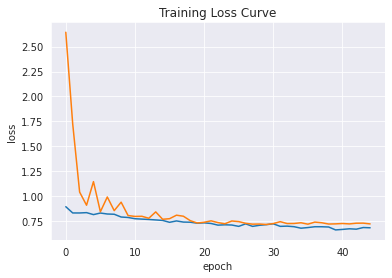

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [18]:
model.load_weights("./xray_class_weights.best.hdf5")

In [19]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator), verbose=True)

525/525 [==============================] - 487s 928ms/step


In [20]:
import util

In [21]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

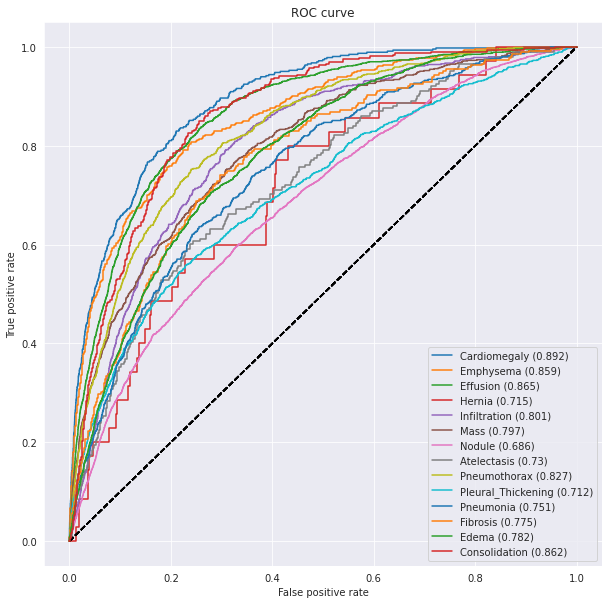

In [22]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [23]:
model.save('finalized.h5')